BAIT 508 Group Project: Industry Analysis

PROJECT OVERVIEW: 
The goal of this project is to conduct an in-depth analysis of public US firms within selected industry sector(s) using various data analyses and natural language processing (NLP) techniques that we learned in BAIT 508. Each team will choose at least one industry sector to investigate and utilize multiple datasets to extract valuable industry insights from the data.

The project will utilize three datasets (located in the data folder):
•	public_firms.csv
•	major_groups.csv
•	2020_10K_item1_full.csv

In [51]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
public_firms=pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\GroupProject\data\public_firms.csv')
twenty20_10K_item1_full=pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\GroupProject\data\2020_10K_item1_full.csv')
major_groups =pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\GroupProject\data\major_groups.csv')

Part 1. Quantitative Analysis of the Industry Sector

A.	[Industry Sector Selection and Data Filtering; 20 points] 

1.	The file "data/major_groups.csv" contains a list of major industry sectors and their corresponding codes (column "major_group"). Your first task is to choose at least one industry sector that interests your group. It is okay if multiple groups choose the same industry sector, so you don’t need to coordinate with other groups.


In [52]:
agri = ( '1','2','7','8','9') #Agriculture and Related Industries
wholesale = ( '50','51') #Wholesale

2.	Next, filter the data in "data/public_firms.csv" to only include the firms belonging to the industry sector(s) you have selected. You can use the "major_group" value, which corresponds to the first two digits of each firm’s SIC code,  to identify relevant firms. For example, if you are interested in the “Business Service” sector and its "major_group" code is 73, you should retain all firms whose SIC codes start with 73. 

In [53]:
industries_agri = public_firms[public_firms['sic'].astype(str).str.startswith(agri)]
industries_wholesale = public_firms[public_firms['sic'].astype(str).str.startswith(wholesale)]
fname_industries = industries_wholesale

3.	Now, answer the following questions based on the filtered dataset: 

a.	How many unique firm-year ("fyear") observations are there in the filtered dataset?


In [54]:
unique_fyear=len(fname_industries['fyear'].unique())
unique_fyear

27

b.	How many unique firms are there in the filtered dataset?



In [55]:
unique_firms = len(fname_industries['conm'].unique())
unique_firms

640

c.	How many firms in the filtered dataset have records over all 27 years (1994-2020)?

In [56]:
filtered_firms = fname_industries.groupby('conm').filter(lambda x: len(x) == unique_fyear)
num_firms = len(filtered_firms['conm'].unique())
num_firms

11

B.	[Preliminary Analysis; 20 points] Answer the following questions:

1.	What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?


In [57]:
top_ten_stocks = fname_industries.sort_values('prcc_c', ascending=False).loc[fname_industries['fyear'] == 2020].head(10)
top_ten_stocks[['conm']]

,conm
17053,GRAINGER (W W) INC
120862,POOL CORP
26157,MITSUI & CO LTD
42140,WATSCO INC
24707,MCKESSON CORP
90303,SITEONE LANDSCAPE SUPPLY INC
95925,CDW CORP
104051,COPART INC
107901,RELIANCE STEEL & ALUMINUM CO
119266,AMCON DISTRIBUTING CO


2.	What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?

In [58]:
top_10_firm = fname_industries.groupby('conm').sum(numeric_only=True).sort_values('sale', ascending=False).head(10)
top_10_firm[['sale']]


,sale
conm,
MCKESSON CORP,2876380.400
MITSUI & CO LTD,2076384.551
CARDINAL HEALTH INC,2043256.797
AMERISOURCEBERGEN CORP,1954792.103
SYSCO CORP,900989.228
INGRAM MICRO INC,613663.628
SUPERVALU INC,563953.937
TECH DATA CORP,542110.884
CHS INC,530901.755


3.	What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations. 

In [59]:
unique_locations = fname_industries.groupby('location')['conm'].nunique().sort_values(ascending=False)
unique_locations

location
USA    575
CHN     22
HKG     10
GBR      7
CAN      4
ISR      4
BRA      2
ARE      2
JPN      2
MEX      1
TWN      1
RUS      1
NLD      1
MYS      1
ANT      1
CYM      1
CHE      1
BMU      1
BEL      1
AUS      1
VGB      1
Name: conm, dtype: int64

4.	Create a line chart to show the average stock price (column "prcc_c") in the selected sector(s) across the years. If you have selected multiple sectors, draw multiple lines to show them separately.


In [60]:

#graph for each pof the sic
# mean_prcc_sic_year = fname_industries.groupby('fyear')['prcc_c'].mean().plot(legend=True)

###5.	Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?

In [61]:

prcc_c_2008 = fname_industries[fname_industries['fyear'] == 2008]
prcc_c_2007 = fname_industries[fname_industries['fyear'] == 2007]
#measured by the percentage drop in stock price for conm column from 2007 to 2008
prcc_c_2008 = fname_industries.loc[fname_industries['fyear'] == 2008]

In [62]:
fname_industries.columns

Index(['gvkey', 'fyear', 'location', 'conm', 'ipodate', 'sic', 'prcc_c', 'ch',
       'ni', 'asset', 'sale', 'roa'],
      dtype='object')

6.	Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.

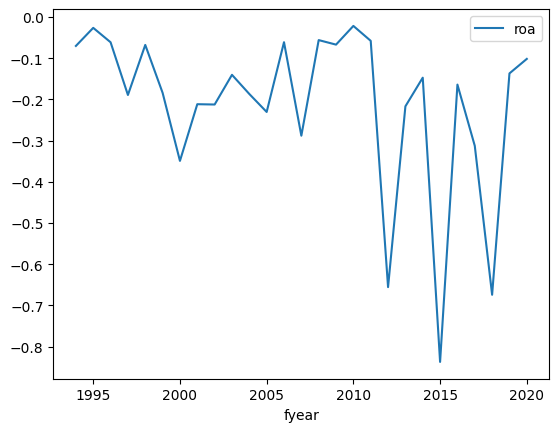

In [63]:
fname_industries_roa = fname_industries.copy()
fname_industries_roa['roa'] = fname_industries['ni'] / fname_industries['asset']
usa_roa_yearly_mean_plot = fname_industries_roa[fname_industries_roa['location'] == 'USA'].groupby('fyear')['roa'].mean().plot(legend=True)

Part 2. Text Analysis on the Industry Sector

C.	[Text Cleaning; 10 points] The file "data/2020_10K_item1_full.csv" contains a sample of 5,988 firms and their “item 1” content in their 10-K reports in the year 2020.  Load the dataset as a DataFrame and create a new column containing the cleaned text for each “item1” content. Follow the steps below to clean the text:

1.	Convert all words to lowercase.


In [64]:
twenty20_10K_item1_clean = twenty20_10K_item1_full.copy()
twenty20_10K_item1_clean['item_1_text'] = twenty20_10K_item1_full['item_1_text'].str.lower()
twenty20_10K_item1_clean

,cik,year,name,item_1_text
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...
1,1693801,2020,"Luxxo, Inc.","corporate history luxxo, inc., formerly known ..."
2,1556179,2020,"RMR Industrials, Inc.",overview rmr s predecessor entity was incorpor...
3,1626696,2020,STAR WEALTH GROUP INC.,business development & business overview we we...
4,315374,2020,HURCO COMPANIES INC,"general hurco companies, inc. is an internatio..."
...,...,...,...,...
5983,1766146,2020,Union Acquisition Corp. II,in this annual report on form 10-k (the form ...
5984,72633,2020,NORTH EUROPEAN OIL ROYALTY TRUST,(a) general development of business. north eur...
5985,1434389,2020,"UNIVERSAL SOLAR TECHNOLOGY, INC.",(a) general development of business. north eur...
5986,1394638,2020,CREATIVE LEARNING Corp,"creative learning corporation, operating under..."


2.	Remove punctuations.

3.	Remove stop words based on the list of English stop words in NLTK.

In [65]:
translator = str.maketrans('', '', string.punctuation)
sw = stopwords.words('english')
def clean_text(text):
    clean_text = text.lower()
    clean_text = clean_text.translate(translator)
    clean_words = [w for w in clean_text.split() if w not in sw]
    return ' '.join(clean_words)

In [66]:
try:
    twenty20_10K_item1_clean = pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\GroupProject\data\twenty20_10K_item1_clean.csv')
except:
    twenty20_10K_item1_clean['item_1_clean'] = twenty20_10K_item1_clean['item_1_text'].apply(clean_text)
    twenty20_10K_item1_clean.to_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\GroupProject\data\twenty20_10K_item1_clean.csv')

D.	[Keyword Analysis; 20 points] Conduct keywords analysis on your selected industry sector(s). Follow the steps below to complete the analysis:

1.	Create a new DataFrame that includes only firms in your selected industry sectors. Ensure that you merge the 10-K data with the previous "public_firm.csv" data using an inner join.


In [67]:
def get_wordcount(text):
    return len(str(text).split())
